# <b><font color="blue"> Exploring MoViNet: Efficient Mobile Video Recognition </font></b>

## <font color="blue"> Introduction </font>
**MoViNet**, short for **Mobile Video Network**, is an advanced video recognition model pecifically optimized for mobile and resource-constrained devices. It leverages cutting-edge techniques such as **Neural Architecture Search (NAS)**, **stream buffering**, and **temporal ensembling** to deliver high accuracy and efficiency in real-time video processing. Designed to handle the unique challenges of video analysis on mobile platforms, MoViNet can process video streams efficiently while maintaining low memory usage, making it suitable for applications ranging from surveillance and healthcare monitoring to sports analytics and smart home systems.


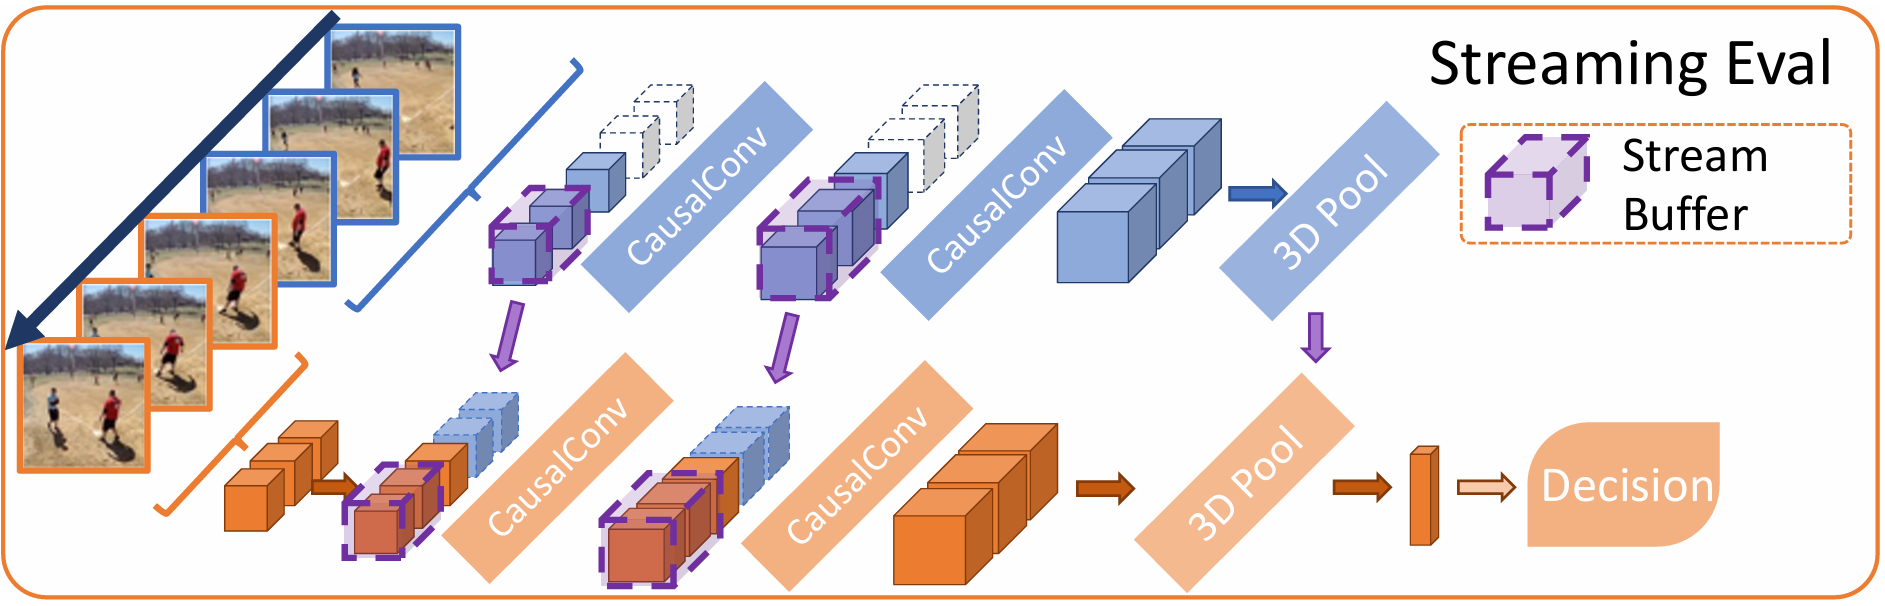

## <font color="blue"> MoViNet search space </font>
The MoViNet search space is a structured approach to designing efficient video recognition models for mobile devices. It starts with a foundation based on MobileNetV3, expanding it into 3D to handle video inputs. By using Neural Architecture Search (NAS), the framework explores different architectural configurations, like kernel sizes, filter widths, and layer depths, to find the best balance between accuracy and efficiency. The goal is to capture the temporal aspects of video data without overwhelming the limited resources available on mobile hardware.

This search space enables the development of a range of models, each optimized for specific use cases. From lightweight models suited for low-power devices to more complex architectures designed for edge computing, the MoViNet framework allows for customization based on the needs of the application. The use of NAS ensures that each model is tailored to achieve the best possible performance within the constraints, making MoViNet a practical solution for mobile video recognition tasks.

## <font color="blue"> Stream Buffers </font>
Stream buffers are used in MoViNet models to reduce memory usage when processing long videos. Instead of evaluating the entire video at once, the video is split into smaller subclips. Stream buffers store the feature information from the edges of these subclips, allowing the model to keep track of information across the entire video without reprocessing overlapping frames. This method preserves long-term dependencies in the video while maintaining efficient memory usage. By using causal operations like CausalConv, the model processes video frames sequentially, making it suitable for real-time video streaming with reduced memory and computational requirements.

## <font color="blue"> Temporal Ensembles </font>
Temporal ensembles in MoViNets help restore the slight accuracy drop caused by using stream buffers. This is done by training two identical models independently, each processing the video at half the original frame rate, but with a one-frame offset between them. The predictions from both models are combined using an arithmetic mean before applying softmax. Despite each model having slightly lower accuracy on its own, the ensemble of the two models provides a more accurate prediction, effectively maintaining accuracy while keeping computational costs low.

## <font color="blue"> Inferencing Pre-trained MoViNet </font>
To harness the power of MoViNet, we need to go through a few key steps: importing necessary libraries, loading the pre-trained model, reading and processing video data, and finally, generating predictions. Let’s dive into each step in detail.

### <font color="blue"> 1. Import necessary libraries </font>

Before we begin, we need to import several essential Python libraries. These libraries provide the tools necessary for video processing and model inference.

* **Numpy :** A powerful Python library for numerical computing, providing support for arrays, matrices, and a wide range of mathematical functions to perform operations on these data structures efficiently.
* **CV2 :** Computer vision and machine learning software library that provides a comprehensive set of tools and functions for image and video analysis, including real-time processing capabilities.
* **TensorFlow :** Framework developed by Google, designed to facilitate the creation, training, and deployment of deep learning models and complex numerical computations.
* **TensorFlow_Hub :** A library for reusable machine learning modules, enabling easy sharing and integration of pre-trained models and components for various tasks such as image classification, text embedding, and more, within TensorFlow workflows.

In [1]:
import numpy as np
import cv2
import tensorflow as tf
import tensorflow_hub as hub
import pathlib

### <font color="blue"> 2. Load the pre-trained model from tensorflow_hub </font>

Next, we need to load the MoViNet model from TensorFlow Hub. This step involves setting up the model architecture and loading the pre-trained weights.

In [ ]:
# Define the URL for the pre-trained MoViNet model from TensorFlow_Hub
hub_url = "https://www.kaggle.com/models/google/movinet/TensorFlow2/a0-base-kinetics-600-classification/3"

# Load the MoViNet encoder layer from TensorFlow_Hub
encoder = hub.KerasLayer( hub_url )

# Define the input tensor with dynamic dimensions for time, height, and width, and 3 channels (RGB)
inputs = tf.keras.layers.Input(
    shape = [ None, None, None, 3 ],
    dtype = tf.float32,
    name = 'image')

# Apply the encoder to the input tensor; it expects a dictionary with the key 'image'
outputs = encoder( dict( image= inputs ) )

# Instantiate the Keras model with the specified inputs and outputs
model = tf.keras.Model( inputs, outputs, name='MoViNet' )

print( model.summary() )

Model: "MoViNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, None, None, Non   0         
                             e, 3)]                              
                                                                 
 keras_layer (KerasLayer)    (None, 600)               3126071   
                                                                 
Total params: 3126071 (11.93 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 3126071 (11.93 MB)
_________________________________________________________________
None


### <font color="blue"> 3. Load the video </font>
With the model ready, the next step is to prepare our video data. This involves reading the video file and processing it into a format suitable for the MoViNet model.

In [ ]:
video_path = r"/content/jumping_video.mp4" # Path to video
vidcap = cv2.VideoCapture(video_path) # Create a VideoCapture object

if not vidcap.isOpened():
    print(f"Error: Could not open video {video_path}")
    exit()

# Read the sequence of frames(video) into a list
video_data = []

while True:
    success, image = vidcap.read()
    if not success:
        break
    image = cv2.resize(image, (172, 172))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    video_data.append(image_rgb)

# Release the video object
vidcap.release()

# Convert the list to a numpy array
video_data = np.array(video_data)

print(video_data.shape)

(26, 172, 172, 3)


### <font color="blue"> 4. Preprocess the video (reshape), input it to model and generate output </font>
Finally, we preprocess the video data and run it through the model to generate predictions. This step involves reshaping the data and interpreting the model’s output.

In [ ]:
video_data= video_data[:5, :, :, :] # For faster inference, considered only 5 frames (Optional, entire sequence from an input video can be passed)

In [ ]:
# Expand dimension of input
input_tensor= tf.expand_dims(video_data, axis= 0)
print(input_tensor.shape) # Print the shape of input tensor

(1, 5, 172, 172, 3)


In [ ]:
logits= model.predict(input_tensor) # Generate prediction from model

max_index= np.argmax( tf.nn.softmax(logits) ) # Apply softmax function on logits and find the index having maximum probability value

1/1 [==============================] - 6s 6s/step


In [ ]:
max_index

388

In [ ]:
# Load index-to-label mapping into an array
labels_path = tf.keras.utils.get_file(
    fname='labels.txt',
    origin='https://raw.githubusercontent.com/tensorflow/models/f8af2291cced43fc9f1d9b41ddbf772ae7b0d7d2/official/projects/movinet/files/kinetics_600_labels.txt'
)
labels_path = pathlib.Path(labels_path)

lines = labels_path.read_text().splitlines()
KINETICS_600_LABELS = np.array([line.strip() for line in lines])

In [ ]:
# Display the output label
KINETICS_600_LABELS[max_index]

'pumping fist'

## <font color="blue"> Strengths of MoViNets </font>
* **High Accuracy:** MoViNets achieve state-of-the-art accuracy on various video recognition benchmarks, demonstrating their ability to effectively extract and learn spatiotemporal features.
* **Memory Efficiency:** Significant reduction in memory usage compared to traditional 3D convolutional networks. Making them suitable for deployment on resource-constrained devices like mobile phones.
* **Online Inference:** Supports online inference, enabling frame-by-frame predictions and efficient processing of streaming video, which is crucial for real-time applications.

## <font color="blue"> Challenges and Limitations </font>
* **Generalization:** MoViNets train with a specific frame rate and clip duration, which may limit their ability to generalize to videos with different temporal characteristics.
* **Limited Search Space:** The design of MoViNets’ search space is based on existing 2D models, which may limit the exploration of novel 3D architectures.
* **Streaming Architecture:** While stream buffers allow for online inference, they can cause a small accuracy drop compared to non-streaming models due to the limitations of causal operations.

## <font color="blue"> Real-World Applications </font>
* **Surveillance and Security:** Can enhance security by enabling real-time detection of objects, activities, and anomalies in surveillance systems, improving safety in public spaces, buildings, and at borders.
* **Healthcare Monitoring:** Can analyze medical images like X-rays and MRIs to assist healthcare professionals in diagnosing and tracking the spread of diseases like cancer.
* **Sports Analytics:** Sports organizations can use video classification to analyze player performance, tactics, and opponent strategies, leading to improved decision-making and player development.
* **Video Conferencing:** Can enable real-time video analysis in video conferencing applications, optimizing video quality, detecting participants’ emotions, and enhancing the overall conferencing experience.
* **Smart Homes:** Smart home systems use MoViNet to analyze security footage in real-time, detect suspicious activity, and alert homeowners.

## <font color="blue"> Conclusion </font>
MoViNets represent a significant breakthrough in efficient video recognition. They demonstrate that powerful video understanding is achievable even on resource-constrained devices like mobile phones. By leveraging stream buffers and causal operations, MoViNets enable real-time inference on streaming video. This capability opens up exciting possibilities for a wide range of applications, including augmented reality, self-driving cars, video conferencing, and mobile gaming.

Despite their impressive accuracy and efficiency, MoViNets have areas for improvement. Further research can focus on expanding their search space. Optimizing their performance across diverse hardware platforms is also crucial. Additionally, enhancing their generalization capabilities can unlock even greater potential in the field of video understanding.